# LightAutoML Задача регресии

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_absolute_error
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [2]:
data = pd.read_csv('data_2/train.csv')
data.shape

(1460, 81)

## Супер быстрый вариант 'на лету'

In [3]:
# определяем target & random_state
target = 'SalePrice'
rs = 42
ts = 0.2

In [4]:
# разделение данных
train_data, test_data = train_test_split(
    data,
    test_size=ts,
    random_state=rs
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data is splitted. Parts sizes: train_data = (1168, 81), test_data = (292, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
638,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000
799,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000


Постановка задачи

In [5]:
# постановка задачи
task = Task('reg', loss='mae', metric='mae')

Определение ролей

**Role** определяют роли каждого столбца. Обязательная роль, которую нужно указать, — это целевая переменная.

Остальной список ролей:

'numeric' — непрерывные признаки

'category' — категориальные признаки

'text' — текстовые данные

'datetime' — даты + время

'date' — даты

'group' — признаки, по которым данные могут быть разделены на группы и которые должны быть использованы при делении при k-фолд валидации

'drop' — признаки, которые нужно удалить перед построением модели

Более полный список по ссылке:

https://lightautoml.readthedocs.io/en/latest/pages/tutorials/Tutorial_1_basics.html

In [6]:
# определение ролей
roles = {
    'target': 'SalePrice',
    'drop': ['Id']
}

## Создание пресета для табличных данных

https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.automl.presets.tabular_presets.TabularAutoML.html#lightautoml.automl.presets.tabular_presets.TabularAutoML

In [7]:
timeout = 360
threads = 4
cv = 5

In [8]:
# настройка алгоритма
automl = TabularAutoML(task = task, # тип задачи
                       timeout = timeout, # максимальная граница времени в секундах
                       cpu_limit = threads, #
                       reader_params = {'n_jobs': threads, 'random_state': rs, 'cv': cv}) # число процессов и прочее

In [9]:
# Вызов алгоритма
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 3) # вызываем fit_predict для обучения и сразу предсказания test

[07:58:20] Stdout logging level is INFO3.
[07:58:20] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[07:58:20] Task: reg

[07:58:20] Start automl preset with listed constraints:
[07:58:20] - time: 360.00 seconds
[07:58:20] - CPU: 4 cores
[07:58:20] - memory: 16 GB

[07:58:20] Train data shape: (1168, 81)

[07:58:30] Feats was rejected during automatic roles guess: []
[07:58:30] Layer 1 train process start. Time left 350.76 secs
[07:58:30] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[07:58:30] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[07:58:30] Linear model: C = 1e-05 score = -183066.00898671697
[07:58:31] Linear model: C = 5e-05 score = -58276.21941773504
[07:58:31] Linear model: C = 0.0001 score = -58275.796674679485
[07:58:31] Linear model: C = 0.0005 score = -58270.370192307695
[07:58:31] Linear model: C = 0.001 score = -58264.130876068375
[07:58:31] Linear model: C = 0.005 score = -58212.09415064102


In [10]:
# достаем лучшую модель
automl.create_model_str_desc()

'Final prediction for new objects (level 0) = \n\t 0.29533 * (3 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +\n\t 0.11522 * (4 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +\n\t 0.06467 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +\n\t 0.41662 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +\n\t 0.10816 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) '

In [11]:
# смотрим метрики на train & test
test_pred = automl.predict(test_data)

print(f'train score: {mean_absolute_error(train_data[target].values, oof_pred.data[:, 0])}')
print(f'test score: {mean_absolute_error(test_data[target].values, test_pred.data[:, 0])}')

train score: 14630.060760916096
test score: 14791.974662885274


In [12]:
# получение важности фич с помощью feature selector, обученного на этапе обучения алгоритма
automl.get_feature_scores('fast') # fast - по быстрому на основе метаданных в обучении

,Feature,Importance
0,GrLivArea,25182.192727
1,OverallQual,18186.045186
2,LotArea,12999.798644
3,YearBuilt,12464.091847
4,GarageArea,11655.925798
...,...,...
73,Street,0.000000
74,Condition2,0.000000
75,RoofMatl,0.000000
76,PoolQC,0.000000


In [13]:
# получение важности фич с помощью permutation score
# (использует расчёт важности фич с расчётом метрик на тестовой выборке)
# permutation score - на сколько изменится метрика если значения фичи ПЕРЕМЕШАТЬ
automl.get_feature_scores('accurate', test_data) # вторым параметром добавляем !!! тестовую выборку

,Feature,Importance
0,GrLivArea,9919.980950
1,OverallQual,6695.237559
2,TotalBsmtSF,2590.498114
3,Neighborhood,2267.198122
4,BsmtFinSF1,1689.345476
...,...,...
73,YrSold,-13.690483
74,Heating,-14.543504
75,EnclosedPorch,-22.093322
76,Condition1,-31.233305


## Тот-же 'на лету' с добавлением новых признаков

In [14]:
def create_features(data):
    data["SqFtPerRoom"] = data["GrLivArea"] / (data["TotRmsAbvGrd"] +
                                               data["FullBath"] +
                                               data["HalfBath"] +
                                               data["KitchenAbvGr"])

    data['Total_Home_Quality'] = data['OverallQual'] + data['OverallCond']

    data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) +
                                   data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))

    data["HighQualSF"] = data["1stFlrSF"] + data["2ndFlrSF"]

    return data


In [15]:
train_data = create_features(train_data)
test_data = create_features(test_data)

In [16]:
# постановка задачи
task = Task('reg', loss='mae', metric='mae')
timeout = 360
threads = 4
cv = 5

# определение ролей
roles = {
    'target': 'SalePrice',
    'drop': ['Id']
}

# настройка алгоритма
automl = TabularAutoML(task = task, # тип задачи
                       timeout = timeout, # максимальная граница времени в секундах
                       cpu_limit = threads, #
                       reader_params = {'n_jobs': threads, 'random_state': rs, 'cv': cv}) # число процессов и прочее
# Вызов алгоритма
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 1) # вызываем fit_predict для обучения и сразу предсказания test

# смотрим метрики на train & test
test_pred = automl.predict(test_data)

print(f'train score: {mean_absolute_error(train_data[target].values, oof_pred.data[:, 0])}')
print(f'test score: {mean_absolute_error(test_data[target].values, test_pred.data[:, 0])}')

[08:03:45] Stdout logging level is INFO.
[08:03:45] Task: reg

[08:03:45] Start automl preset with listed constraints:
[08:03:45] - time: 360.00 seconds
[08:03:45] - CPU: 4 cores
[08:03:45] - memory: 16 GB

[08:03:45] Train data shape: (1168, 85)

[08:03:52] Layer 1 train process start. Time left 352.61 secs
[08:03:53] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[08:04:13] Time limit exceeded after calculating fold 2

[08:04:13] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -16720.722202746616
[08:04:13] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[08:04:13] Time left 331.26 secs

[08:04:18] Selector_LightGBM fitting and predicting completed
[08:04:19] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[08:04:45] Time limit exceeded after calculating fold 3

[08:04:45] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -15277.576570855616
[08:04:45] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[08:04:45] Start hyperparameters optimization for Lv

## Используем TabularUtilizedAutoML для более эффективного использования времени

In [17]:
# используем предыдущие настройки
automl = TabularUtilizedAutoML(task = task, # тип задачи
                       timeout = timeout, # максимальная граница времени в секундах
                       cpu_limit = threads, #
                       reader_params = {'n_jobs': threads, 'random_state': rs, 'cv': cv}) # число процессов и прочее
# Вызов алгоритма
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 1) # вызываем fit_predict для обучения и сразу предсказания test

# смотрим метрики на train & test
test_pred = automl.predict(test_data)

print(f'train score: {mean_absolute_error(train_data[target].values, oof_pred.data[:, 0])}')
print(f'test score: {mean_absolute_error(test_data[target].values, test_pred.data[:, 0])}')

[08:07:53] Start automl utilizator with listed constraints:
[08:07:53] - time: 360.00 seconds
[08:07:53] - CPU: 4 cores
[08:07:53] - memory: 16 GB

[08:07:53] If one preset completes earlier, next preset configuration will be started

[08:07:53] ==================================================
[08:07:53] Start 0 automl preset configuration:
[08:07:53] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[08:07:53] Stdout logging level is INFO.
[08:07:53] Task: reg

[08:07:53] Start automl preset with listed constraints:
[08:07:53] - time: 359.99 seconds
[08:07:53] - CPU: 4 cores
[08:07:53] - memory: 16 GB

[08:07:53] Train data shape: (1168, 85)

[08:07:54] Layer 1 train process start. Time left 358.87 secs
[08:07:55] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[08:08:13] Time limit exceeded after calculating fold 1

[08:08:13] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished

## Итоговый вариант, формируем отчет

In [18]:
# обновим данные
data = pd.read_csv('data_2/train.csv')
# разделяем данные
train_data, test_data = train_test_split(
    data,
    test_size=0.2,
    random_state=42
    )

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

Data is splitted. Parts sizes: train_data = (1168, 81), test_data = (292, 81)


In [19]:
# новые признаки
train_data = create_features(train_data)
test_data = create_features(test_data)

In [20]:
# определяем target
target = 'SalePrice'
# постановка задачи
task = Task('reg', loss='mae', metric='mae')

timeout = 360
threads = 4
cv = 5

# определение ролей
roles = {
    'target': 'SalePrice',
    'drop': ['Id']
}

# настройка алгоритма
automl = TabularAutoML(task = task, # тип задачи
                       timeout = timeout, # максимальная граница времени в секундах
                       cpu_limit = threads, #
                       reader_params = {'n_jobs': threads, 'random_state': rs, 'cv': cv}) # число процессов и прочее


In [21]:
# оборачиваем алгоритм для формирования отчета
RD = ReportDeco(output_path = 'tabularAutoML_model_report') # указываем путь сохранения отчета
# RD - обертка для таски
automl_rd = RD(
    automl
)

In [22]:
oof_pred = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

[08:12:04] Stdout logging level is INFO.
[08:12:04] Task: reg

[08:12:04] Start automl preset with listed constraints:
[08:12:04] - time: 360.00 seconds
[08:12:04] - CPU: 4 cores
[08:12:04] - memory: 16 GB

[08:12:04] Train data shape: (1168, 85)

[08:12:05] Layer 1 train process start. Time left 358.60 secs
[08:12:06] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[08:12:23] Time limit exceeded after calculating fold 1

[08:12:23] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -16391.066076555824
[08:12:23] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[08:12:23] Time left 340.44 secs

[08:12:35] Selector_LightGBM fitting and predicting completed
[08:12:36] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[08:13:04] Time limit exceeded after calculating fold 1

[08:13:04] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -14960.79271834936
[08:13:04] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[08:13:04] Start hyperparameters optimization for Lvl

/home/leostuchchi/anaconda3/envs/LAMA/lib/python3.9/site-packages/lightautoml/report/report_deco.py:322: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data["y_pred"] - data["y_true"], shade=True, color="m", ax=ax)


In [23]:
# смотрим метрики на train & test
test_pred = automl_rd.predict(test_data)

print(f'train score: {mean_absolute_error(train_data[target].values, oof_pred.data[:, 0])}')
print(f'test score: {mean_absolute_error(test_data[target].values, test_pred.data[:, 0])}')

/home/leostuchchi/anaconda3/envs/LAMA/lib/python3.9/site-packages/lightautoml/report/report_deco.py:322: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data["y_pred"] - data["y_true"], shade=True, color="m", ax=ax)


train score: 14395.316633668665
test score: 14500.037845141267


In [24]:
# файлы отчета
!ls tabularAutoML_model_report

feature_importance.png		  valid_pie_f1_metric.png
lama_interactive_report.html	  valid_pr_curve.png
test_error_hist_1.png		  valid_preds_distribution_by_bins.png
test_scatter_plot_1.png		  valid_roc_curve.png
test_target_distribution_1.png	  valid_scatter_plot.png
valid_distribution_of_logits.png  valid_target_distribution.png
valid_error_hist.png


<Axes: xlabel='Feature'>

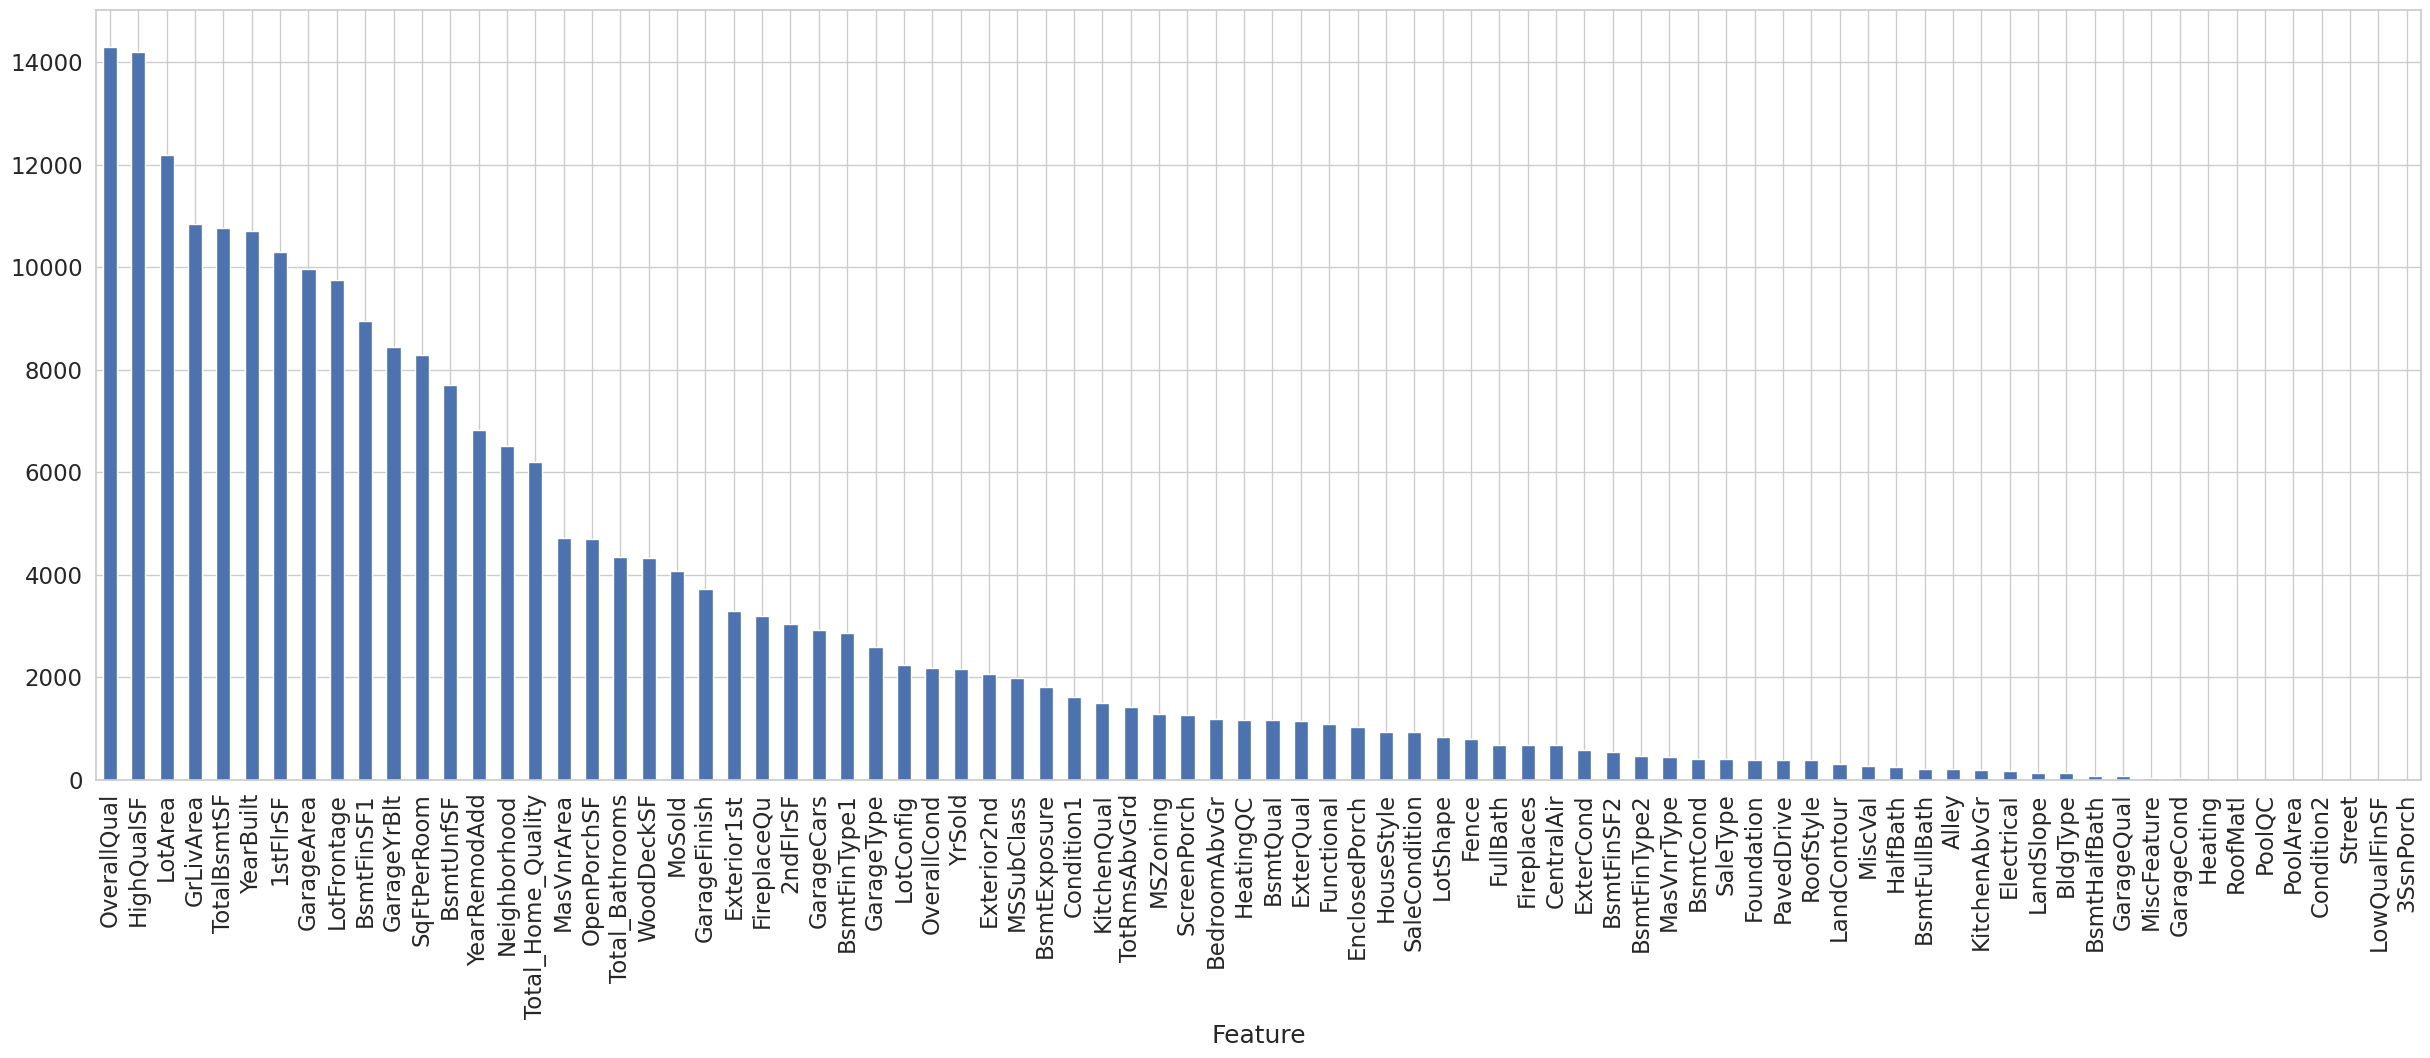

In [25]:
# методы использованные ранее без декоратора так-же работают
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)